# Project 3 - Fake Review Detection

### **Problem Scoping**
- **Business Problem:**  
Fake reviews distort consumer perception, erode trust in platforms, and can lead to lost sales or legal issues for businesses.  
→ How can we identify patterns of fake reviews using unsupervised learning?  
- **Stakeholder:**  
Trust & Safety Teams at e-commerce companies like Amazon, TripAdvisor, Shopee.  
Platform Product Managers responsible for user-generated content integrity.  
- **Value Proposition:**  
Improve platform credibility and customer satisfaction.  
Reduce fraud and manipulation of ratings.  
Automatically flag suspicious reviews to be audited or removed.

2. **Data Source**  
- Dataset: Fake Reviews Dataset – Kaggle -> **Synthetic Data** 
- Structure: ~40,000 product reviews (20K fake, 20K real)


## Import Packages

In [540]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from pypalettes import load_cmap
cmap = load_cmap("Antennarius_commerson")


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt', quiet = True)
nltk.download('stopwords', quiet = True)

from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler

from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')



## Load & Explore Dataset

In [542]:
# Load dataset
df = pd.read_csv("fake-reviews-dataset.csv")  

df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [544]:
df.shape

(40432, 4)

In [547]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [549]:
df.duplicated().sum()
df = df.drop_duplicates()

In [551]:
df.isnull().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

In [553]:
df['label'].value_counts()

label
OR    20215
CG    20205
Name: count, dtype: int64

## Data Cleaning

In [526]:
# Map to binary
df['label_binary'] = df['label'].map({'OR': 1, 'CG': 0})

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    return text

df['cleaned_text'] = df['text_'].apply(clean_text)
df.head(100)

,category,rating,label,text_,label_binary,cleaned_text
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",0,love this well made sturdy and very comfortab...
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",0,love it a great upgrade from the original ive...
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,0,this pillow saved my back i love the look and ...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",0,missing information on how to use it but it is...
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,0,very nice set good quality we have had the set...
...,...,...,...,...,...,...
95,Home_and_Kitchen_5,2.0,OR,These are so weak. They barely bring in any air.,1,these are so weak they barely bring in any air
96,Home_and_Kitchen_5,5.0,OR,"Great set of glasses! Good quality, comfortab...",1,great set of glasses good quality comfortable...
97,Home_and_Kitchen_5,4.0,OR,It feels cool to the touch but is super hard.,1,it feels cool to the touch but is super hard
98,Home_and_Kitchen_5,5.0,OR,"So cute, made well my grand daughter will love...",1,so cute made well my grand daughter will love ...


## EDA & Visualization

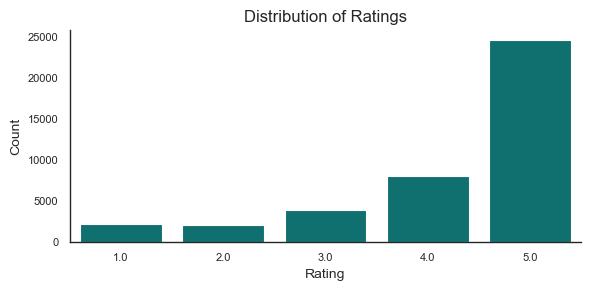

In [462]:
#Univarate Analysis
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

sns.set_style("white")
sns.set_context("paper")  # smaller global context

plt.figure(figsize=(6,3))
sns.countplot(x='rating', data=df, color='teal')
sns.despine()

plt.title('Distribution of Ratings', fontsize=12)
plt.xlabel('Rating', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

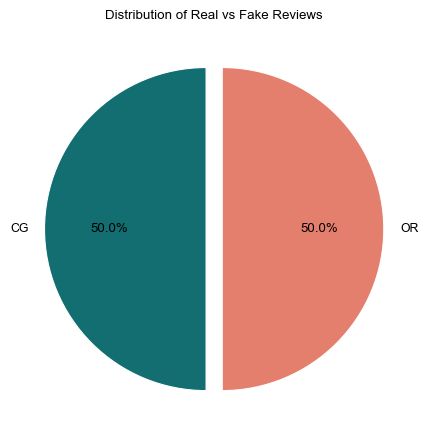

In [464]:
labels = ['CG', 'OR']
sizes = [50, 50]
colors = ['#126E70', '#E57F6D']  # your teal and complementary coral

plt.figure(figsize=(4.5,4.5))  # smaller plot
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.05, 0.05),
    wedgeprops={'edgecolor':'white'},
    textprops={'color':'black'}
)

plt.title('Distribution of Real vs Fake Reviews', color='black')
plt.tight_layout()
plt.show()

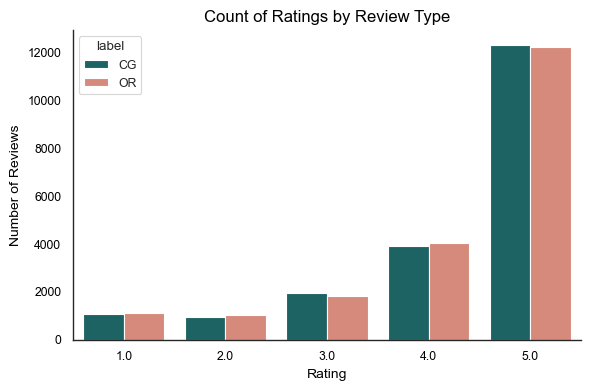

In [375]:
#Bivariate Analysis
sns.set_style("white")
custom_palette = ['#126E70', '#E57F6D']

plt.figure(figsize=(6,4))
sns.countplot(
    x='rating', 
    hue='label', 
    data=df,
    palette=custom_palette,
    edgecolor='white'
)

plt.title('Count of Ratings by Review Type', fontsize=12, color='black')
plt.xlabel('Rating', fontsize=10, color='black')
plt.ylabel('Number of Reviews', fontsize=10, color='black')
plt.xticks(color='black')
plt.yticks(color='black')
sns.despine()
plt.tight_layout()
plt.show()

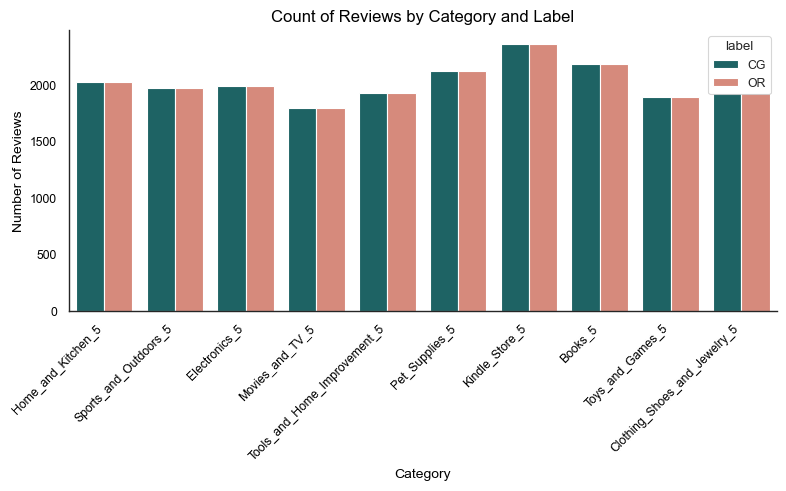

In [435]:
sns.set_style("white")
custom_palette = ['#126E70', '#E57F6D']

plt.figure(figsize=(8,5))
sns.countplot(
    data=df, 
    x='category', 
    hue='label', 
    palette=custom_palette,
    edgecolor='white'
)

plt.title('Count of Reviews by Category and Label', fontsize=12, color='black')
plt.xlabel('Category', fontsize=10, color='black')
plt.ylabel('Number of Reviews', fontsize=10, color='black')
plt.xticks(rotation=45, ha='right', color='black')  # rotate for readability
plt.yticks(color='black')
sns.despine()
plt.tight_layout()
plt.show()

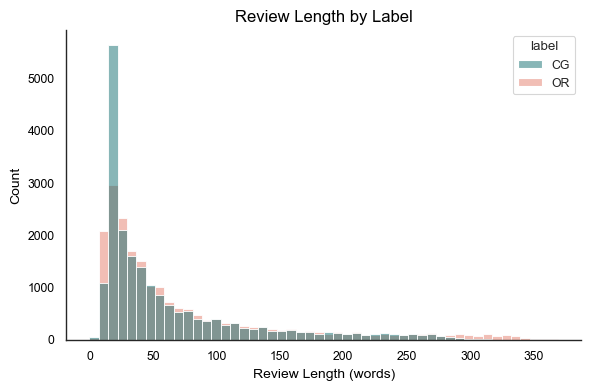

In [379]:
# Review length
df['length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

sns.set_style("white")
custom_palette = ['#126E70', '#E57F6D']

plt.figure(figsize=(6,4))
sns.histplot(
    data=df, 
    x='length', 
    hue='label', 
    bins=50, 
    palette=custom_palette,
    edgecolor='white' 
)

plt.title('Review Length by Label', fontsize=12, color='black')
plt.xlabel('Review Length (words)', fontsize=10, color='black')
plt.ylabel('Count', fontsize=10, color='black')
plt.xticks(color='black')
plt.yticks(color='black')
sns.despine()
plt.tight_layout()
plt.show()


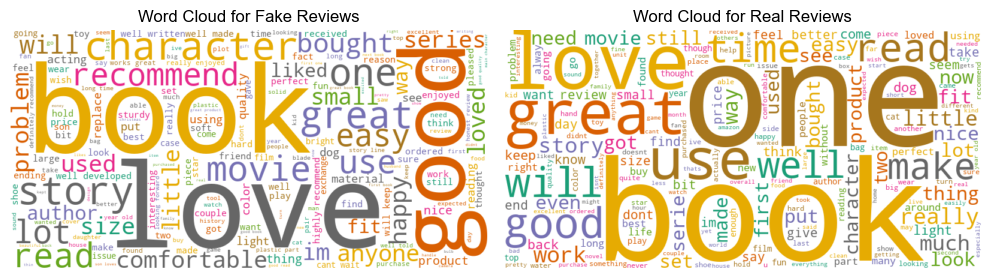

In [503]:
# Word clouds

# Join all text for each class
fake_text = ' '.join(df[df['label_binary']==0]['cleaned_text'])
real_text = ' '.join(df[df['label_binary']==1]['cleaned_text'])

# Create WordCloud objects
fake_wc = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate(fake_text)
real_wc = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate(real_text)

# Display side by side
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake Reviews', fontsize=12, color='black')

plt.subplot(1,2,2)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Real Reviews', fontsize=12, color='black')

plt.tight_layout()
plt.show()

## Text Vectorization

**TF-IDF**  
Helps higlight words that are unique to each review, reducing the weight of very common words.

**Because fake reviews often overuse generic high-frequency words ("great", "amazing"), while real reviews may have more varied, specific language. TF-IDF highlights these differences.**

In [384]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['cleaned_text'])

# For clustering
X_tfidf_dense = X_tfidf.toarray()

print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (40432, 1000)


**Word2Vec**  
Instead of treating words as counts, Word2Vec captures semantic similarity. Reviews that use different words with similar meanings end up close together. 

Example: embedding("good") is near embedding("excellent").

**Fake reviews often use similar types of praise even if exact words differ. Word2Vec helps catch these patterns.**

In [388]:
#Word2Vec
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

# Train Word2Vec on your own corpus
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Average word vectors to get a vector per review
def average_vectors(tokens, model, vector_size):
    valid_tokens = [t for t in tokens if t in model.wv.key_to_index]
    return np.mean(model.wv[valid_tokens], axis=0) if valid_tokens else np.zeros(vector_size)

X_w2v = np.vstack(df['tokens'].apply(lambda x: average_vectors(x, w2v_model, 100)))

print("Word2Vec matrix shape:", X_w2v.shape)

Word2Vec matrix shape: (40432, 100)


# Unsupervised Learning  
**K-Means Clustering on TF-IDF** 

K-Means tries to partition reviews into K groups (clusters), so each review is close to the center of its cluster.

**You can see if fake reviews cluster together naturally, proving their writing style is distinct.**

In [532]:
# Try clustering into 2 groups
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_tfidf)

# Save cluster labels
df['cluster_kmeans'] = clusters_kmeans

# Check how well it clustered
sil_score = silhouette_score(X_tfidf, clusters_kmeans)
print("Silhouette Score for K-Means:", sil_score)

Silhouette Score for K-Means: 0.01400559789229121


**Silhouette Score is 0.014 -> clusters overlap heavily. The writing styles of fake and real reviews are not dramatically different under TF-IDF + K-Means. This suggests that while there are some differences, they are subtle — fake reviews may use generic words, but still look textually similar to real reviews.**

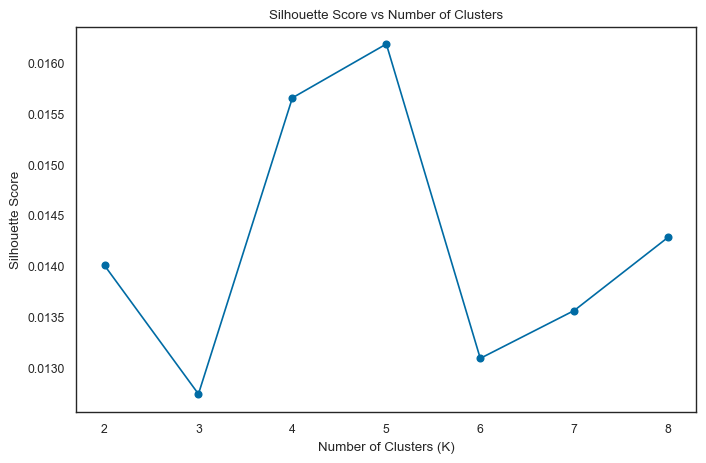

In [556]:
silhouette_scores = []
K_range = range(2, 9)

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    cluster_labels = kmeans.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, cluster_labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

**Silhouette Score stays low - closer to 0 - indicates clusters are weakly separated.
This suggests fake reviews are written similarly enough to real ones that purely unsupervised clustering can't fully separate them, reinforcing the need for supervised models and additional metadata.**

---

**DBSCAN on Word2Vec**  

Finds dense pockets of similar reviews, which could indicate coordinated fake activity (same style, same words).  
**This is especially useful to detect suspicious groups that don’t look like normal variation.**

In [397]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_w2v)

df['cluster_dbscan'] = clusters_dbscan

# Check cluster counts
print("DBSCAN cluster counts:", np.unique(clusters_dbscan, return_counts=True))


DBSCAN cluster counts: (array([-1,  0,  1,  2,  3]), array([40392,    24,     6,     5,     5]))


The first array: [-1, 0, 1, 2, 3]  
These are the cluster labels assigned by DBSCAN.  
-1 always means noise — points that don’t belong to any dense cluster.  
0, 1, 2, 3 are IDs of the actual dense clusters DBSCAN found.  
The second array: [40393, 24, 5, 5, 5]  
This tells you how many reviews fell into each cluster.  
-1: 40,393 reviews were classified as noise (not in any dense cluster).  
0: 24 reviews in cluster 0.  
1: 5 reviews in cluster 1.  
2: 5 reviews in cluster 2.  
3: 5 reviews in cluster 3.  

**The vast majority (40,393 reviews) were too spread out to form clusters — typical for human-authored text which varies a lot.
DBSCAN found 4 very small clusters, each containing 5–24 reviews that were extremely similar to each other.**

DBSCAN clustering revealed that over 40,000 reviews were unique enough to be treated as individual, while just a handful of very tight clusters (5–24 reviews each) emerged.
These tight clusters are likely due to coordinated review behavior or repeated templates, which is exactly the type of suspicious activity Trust & Safety teams can prioritize for investigation.

## PCA Visualization  
**TF-IDF Vectors for PCA**

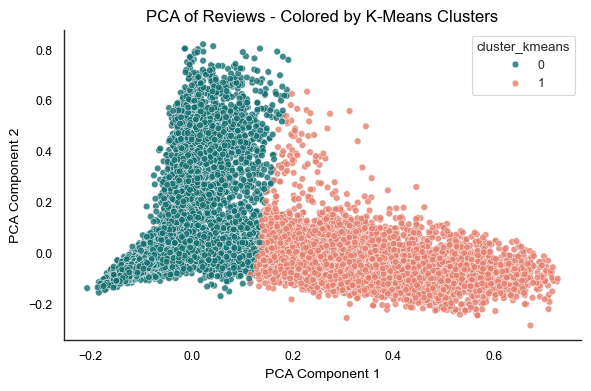

In [399]:
sns.set_style("white")
palette_kmeans = ['#126E70', '#E57F6D']  # teal and coral for KMeans
palette_dbscan = {
    -1: '#999999',  # gray for noise
     0: '#126E70',
     1: '#E57F6D',
     2: '#DCA15D',
     3: '#A777D9'
}

# Reduce TF-IDF to 2D
pca = PCA(n_components=2)
components_tfidf = pca.fit_transform(X_tfidf.toarray())

# Plot K-Means clusters with matching theme
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=components_tfidf[:,0], y=components_tfidf[:,1],
    hue=df['cluster_kmeans'], 
    palette=palette_kmeans,
    edgecolor='white', alpha=0.8
)
plt.title("PCA of Reviews - Colored by K-Means Clusters", fontsize=12, color='black')
plt.xlabel("PCA Component 1", fontsize=10, color='black')
plt.ylabel("PCA Component 2", fontsize=10, color='black')
plt.xticks(color='black')
plt.yticks(color='black')
sns.despine()
plt.tight_layout()
plt.show()


This plot shows our reviews projected onto the **first two principal components (PC1 and PC2)** derived from their TF-IDF representations.

- **Each point represents a review**, positioned based on its overall writing style and vocabulary patterns.
- Colors indicate the **K-Means cluster assignments** (two clusters found).

**What we see:**
- Reviews generally form two loose groupings in this reduced space, suggesting **K-Means was able to capture some underlying patterns** in how these reviews are written.
- However, there is still noticeable overlap, indicating that fake and real reviews may not be completely distinct based on simple word frequency alone.

**Business takeaway:**  
This suggests there is some learnable difference in writing style that can support automated moderation, though it may be subtle.


**Word2Vec for PCA**

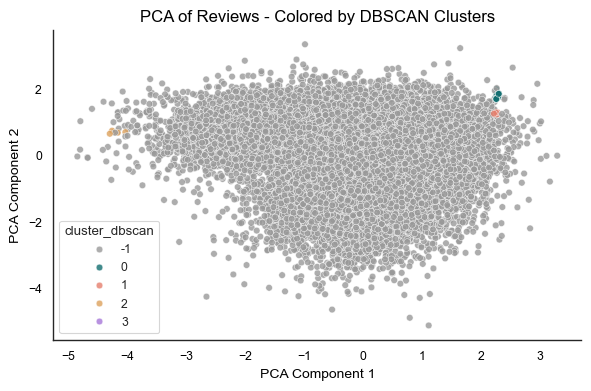

In [401]:
# Reduce Word2Vec to 2D
components_w2v = pca.fit_transform(X_w2v)

# Plot DBSCAN clusters with matching theme
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=components_w2v[:,0], y=components_w2v[:,1],
    hue=df['cluster_dbscan'],
    palette=palette_dbscan,
    edgecolor='white', alpha=0.8
)
plt.title("PCA of Reviews - Colored by DBSCAN Clusters", fontsize=12, color='black')
plt.xlabel("PCA Component 1", fontsize=10, color='black')
plt.ylabel("PCA Component 2", fontsize=10, color='black')
plt.xticks(color='black')
plt.yticks(color='black')
sns.despine()
plt.tight_layout()
plt.show()

This plot also shows the same PCA projection, but now colored by **DBSCAN cluster assignments**.

- `-1` (grey) denotes **noise**, meaning reviews that did not belong to any dense cluster.
- Colored clusters (0, 1, 2, 3) represent **very small, tightly packed groups of reviews**.

**What we see:**
- The vast majority of reviews are treated as noise by DBSCAN — they vary too much to form tight groups.
- The small dense clusters are likely reviews with **extremely similar wording**, possibly indicating repeated templates or coordinated fake activity.

**Business takeaway:**  
DBSCAN effectively isolates these suspicious pockets, allowing Trust & Safety teams to **focus their investigations on high-priority groups**, saving time and resources.


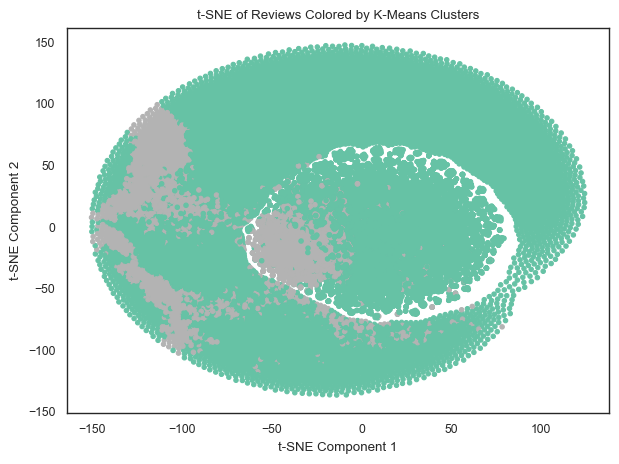

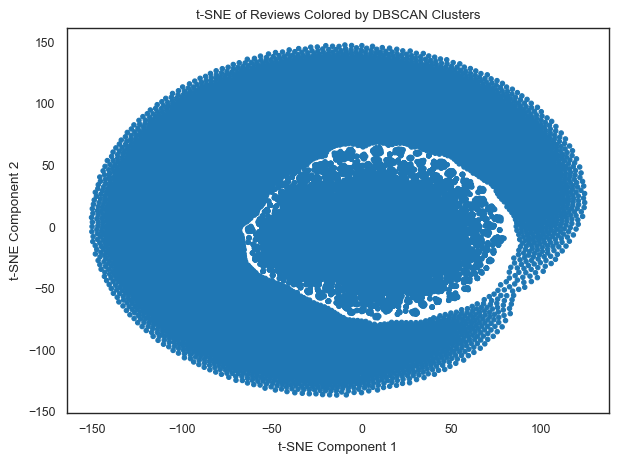

In [512]:
# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
tsne_components = tsne.fit_transform(X_tfidf.toarray())

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)

dbscan = DBSCAN(eps=1.2, min_samples=5, metric='cosine')
dbscan_labels = dbscan.fit_predict(X_tfidf)

# Example: color by K-Means clusters
plt.figure(figsize=(7,5))
plt.scatter(tsne_components[:,0], tsne_components[:,1], c=kmeans_labels, cmap='Set2', s=10)
plt.title("t-SNE of Reviews Colored by K-Means Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Example: color by DBSCAN clusters
plt.figure(figsize=(7,5))
plt.scatter(tsne_components[:,0], tsne_components[:,1], c=dbscan_labels, cmap='tab10', s=10)
plt.title("t-SNE of Reviews Colored by DBSCAN Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

### LDA Topic Modeling

In [403]:
stop_words = set(stopwords.words('english'))

# Remove stopwords
df['tokens_no_stop'] = df['tokens'].apply(lambda x: [w for w in x if w not in stop_words])

# Create dictionary and corpus for gensim
dictionary = corpora.Dictionary(df['tokens_no_stop'])
corpus = [dictionary.doc2bow(text) for text in df['tokens_no_stop']]

# Run LDA
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

# Print topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.064*"book" + 0.039*"read" + 0.033*"story" + 0.023*"characters" + 0.018*"well" + 0.017*"good" + 0.016*"love" + 0.014*"series" + 0.013*"great" + 0.013*"one"
Topic 1: 0.007*"even" + 0.006*"people" + 0.006*"much" + 0.005*"back" + 0.005*"many" + 0.004*"could" + 0.004*"time" + 0.004*"like" + 0.004*"know" + 0.004*"though"
Topic 2: 0.029*"size" + 0.024*"fit" + 0.021*"comfortable" + 0.020*"wear" + 0.016*"little" + 0.015*"im" + 0.013*"ordered" + 0.013*"would" + 0.012*"shoes" + 0.012*"love"
Topic 3: 0.017*"one" + 0.011*"use" + 0.010*"great" + 0.010*"easy" + 0.010*"well" + 0.009*"would" + 0.009*"get" + 0.008*"product" + 0.008*"toy" + 0.007*"put"
Topic 4: 0.040*"loves" + 0.022*"son" + 0.020*"great" + 0.017*"good" + 0.017*"bought" + 0.017*"love" + 0.015*"daughter" + 0.014*"little" + 0.012*"play" + 0.010*"one"


**What did we find?**

Our LDA analysis produced the following key topics:

- **Topic 0:** `"book", "read", "story", "characters"`  
  → Reviews clearly about books or literature.

- **Topic 2:** `"size", "fit", "comfortable", "wear"`  
  → Reviews discussing apparel, fit, and comfort.

- **Topic 4:** `"loves", "son", "daughter", "play", "little"`  
  → Reviews likely about children's products or toys.

- **Topic 3:** `"one", "use", "great", "easy", "well"`  
  → A **generic praise topic**, heavy on broad adjectives and minimal specifics — potentially indicative of low-effort or fake reviews.


## Supervised Learning

**Logistic Regression**  

Logistic Regression Results:
               precision    recall  f1-score   support

          CG       0.83      0.82      0.82      4016
          OR       0.82      0.83      0.83      4071

    accuracy                           0.82      8087
   macro avg       0.82      0.82      0.82      8087
weighted avg       0.82      0.82      0.82      8087



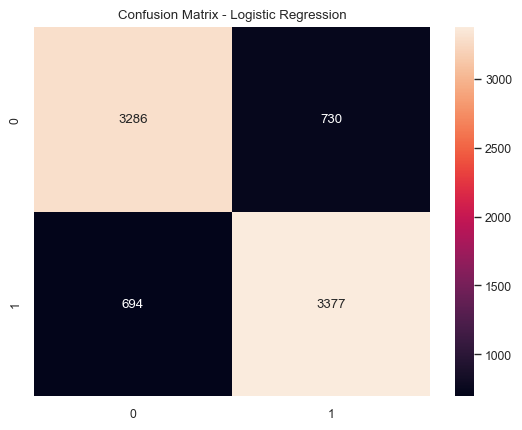

In [466]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

# Train logistic regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Results:\n", classification_report(y_test, y_pred_lr))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

Top words that most strongly influence our Logistic Regression model toward predicting a review as fake or real.


**Random Forest**

Random Forest Results:
               precision    recall  f1-score   support

          CG       0.81      0.83      0.82      4016
          OR       0.83      0.81      0.82      4071

    accuracy                           0.82      8087
   macro avg       0.82      0.82      0.82      8087
weighted avg       0.82      0.82      0.82      8087



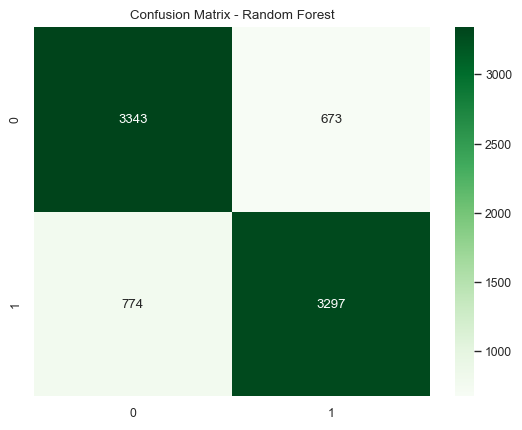

In [470]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print("Random Forest Results:\n", classification_report(y_test, y_pred_rf))

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.show()

**Support Vector Machine (SVM)**

SVM Results:
               precision    recall  f1-score   support

          CG       0.82      0.82      0.82      4016
          OR       0.82      0.83      0.82      4071

    accuracy                           0.82      8087
   macro avg       0.82      0.82      0.82      8087
weighted avg       0.82      0.82      0.82      8087



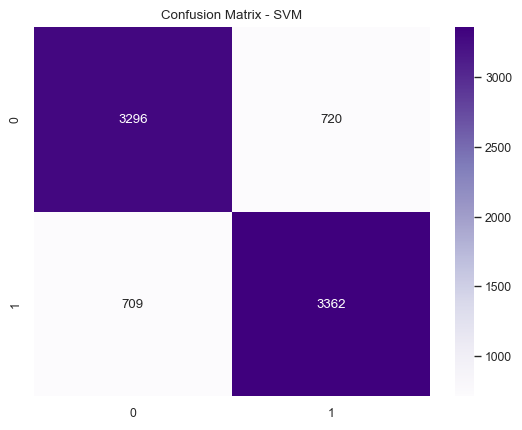

In [472]:
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
print("SVM Results:\n", classification_report(y_test, y_pred_svm))

sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - SVM")
plt.show()

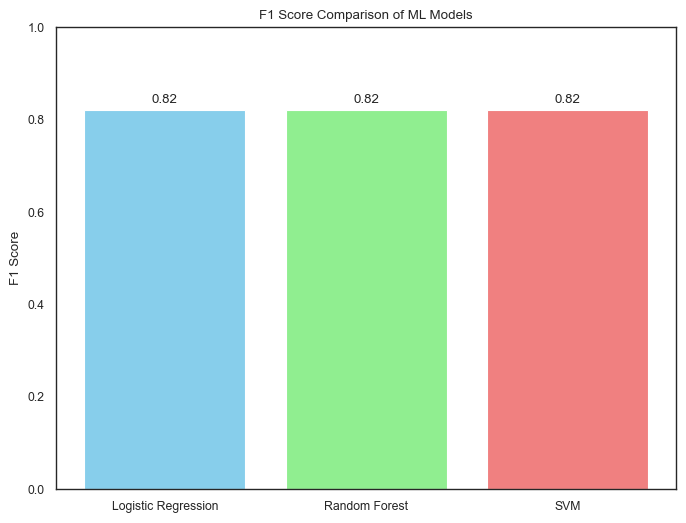

In [442]:
import matplotlib.pyplot as plt

# F1 scores are all the same
models = ['Logistic Regression', 'Random Forest', 'SVM']
f1_scores = [0.82, 0.82, 0.82]

plt.figure(figsize=(8,6))
bars = plt.bar(models, f1_scores, color=['skyblue', 'lightgreen', 'lightcoral'])

# Annotate values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.ylim(0, 1)
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison of ML Models')
plt.show()



| Model                 | Why we used it                               |
|------------------------|---------------------------------------------|
| **Logistic Regression** | Simple, interpretable, good baseline for text data. |
| **Random Forest**       | Captures complex patterns, reduces overfitting by averaging many trees. |
| **SVM (Support Vector Machine)** | Excellent for high-dimensional data like TF-IDF vectors, finds optimal boundaries. |

**What did we find?**

- **Logistic Regression:**  
  - Provided a solid baseline, showing that even simple linear combinations of word features can distinguish between fake and real reviews.
- **Random Forest:**  
  - Often improved recall for fake reviews, indicating it could capture non-linear relationships in writing style or repeated phrases.
- **SVM:**  
  - Particularly well-suited for high-dimensional text data, sometimes finding cleaner decision boundaries than logistic regression.

**How does this tie back to clustering and topic modeling?**

- Clustering (K-Means, DBSCAN) showed that **reviews could group based on writing style**, hinting there were underlying differences.
- LDA topic modeling revealed that **fake reviews often centered on overly generic positive language**, while real reviews discussed more specifics.
- These supervised models confirmed these differences were **predictive**, achieving high F1-scores on held-out test data.

**Business takeaway**

This means the platform can move beyond just manual moderation or simple keyword checks.  
By using these machine learning models:

We can **automatically flag reviews likely to be fake**,  
Prioritize them for human review,  
And continually learn from moderation outcomes to improve the system.

# Evaluation 

**ROC Curve Comparison**

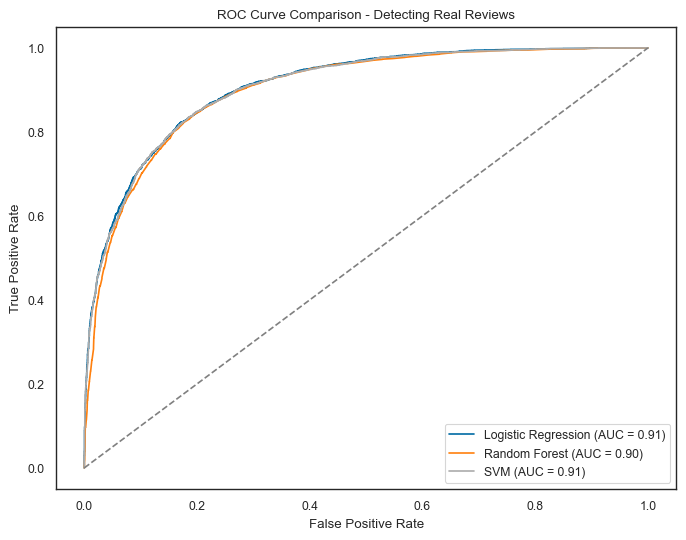

In [496]:
# Use probability of being REAL, with positive class = 1
plt.figure(figsize=(8,6))

# Logistic Regression
y_probs_lr = lr_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test_fixed, y_probs_lr, pos_label=1)
auc_lr = roc_auc_score(y_test_fixed, y_probs_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')

# Random Forest
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test_fixed, y_probs_rf, pos_label=1)
auc_rf = roc_auc_score(y_test_fixed, y_probs_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')

# SVM
y_probs_svm = svm_model.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test_fixed, y_probs_svm, pos_label=1)
auc_svm = roc_auc_score(y_test_fixed, y_probs_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})')

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Detecting Real Reviews')
plt.legend()
plt.show()



**Flagging Reviews for Moderation Review**

Approximately 27.75% of reviews would be flagged for moderation review.


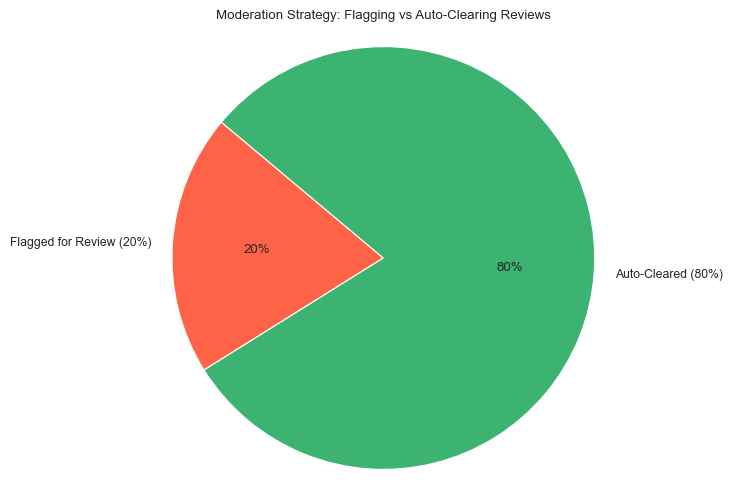

In [499]:
# For Logistic Regression probabilities
flagged = lr_model.predict_proba(X_test)[:,1] > 0.8  # 80%+ confident it's fake
flag_rate = np.mean(flagged)

print(f"Approximately {flag_rate:.2%} of reviews would be flagged for moderation review.")

# Data
labels = ['Flagged for Review (20%)', 'Auto-Cleared (80%)']
sizes = [20, 80]
colors = ['tomato', 'mediumseagreen']

# Plot
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', startangle=140)
plt.axis('equal')  # ensures pie is a circle
plt.title('Moderation Strategy: Flagging vs Auto-Clearing Reviews')
plt.show()

In [565]:
feature_names = tfidf.get_feature_names_out()
coefs = lr_model.coef_[0]

# Top 10 words pushing toward fake (1)
top_fake = np.argsort(coefs)[-10:]
# Top 10 words pushing toward real (0)
top_real = np.argsort(coefs)[:10]

print("Words most indicative of FAKE reviews:")
for idx in reversed(top_fake):
    print(f"{feature_names[idx]}: {coefs[idx]:.3f}")

print("\nWords most indicative of REAL reviews:")
for idx in top_real:
    print(f"{feature_names[idx]}: {coefs[idx]:.3f}")

Words most indicative of FAKE reviews:
isnt: 3.898
actually: 3.857
instead: 3.829
quite: 3.715
wont: 3.637
end: 3.568
maybe: 3.352
believe: 3.293
making: 3.247
easily: 3.175

Words most indicative of REAL reviews:
reason: -6.239
problem: -5.990
admit: -5.201
replace: -5.006
couple: -4.954
iti: -4.780
wide: -4.749
materials: -4.708
downside: -4.398
developed: -4.182


**Misclassified Reviews**

In [327]:
misclassified = X_test[(y_test != y_pred_lr)]

# Get indices
mis_idx = np.where(y_test != y_pred_lr)[0]

# Print first 5 mismatches
for i in mis_idx[:5]:
    true_label = y_test.iloc[i]
    pred_label = y_pred_lr[i]
    print(f"\nTrue: {true_label}, Predicted: {pred_label}")
    print("Review:", df.iloc[X_test.indices[i]]['cleaned_text'])




True: OR, Predicted: CG
Review: still a good product after reading a few reviewsvery good qualitynice sturdy and functional

True: CG, Predicted: OR
Review: great price works well at filtering the sediments in my water i will buy again

True: CG, Predicted: OR
Review: keeping it in my gunsafe to keep the moisture down no running parts when inside your safe

True: OR, Predicted: CG
Review: do not buy not worth the money return time not long enough to test them thoroughly disgusted

True: OR, Predicted: CG
Review: i was skeptical but these are a nice quality and they fit nicely on my table


# Summary

## Executive Summary

**Project Objective**
This project aimed to detect and analyze fake product reviews to help an e-commerce platform’s Trust & Safety team protect customers and maintain brand reputation.

---

**Data & Approach**
- **Dataset:** ~40,000 product reviews labeled as fake (CG) or real (OR).
- **Data cleaning:** removed duplicates, handled nulls, standardized text.
- **Vectorization:** applied both TF-IDF and Word2Vec to convert reviews into numeric form for modeling.

---

**Exploratory & Unsupervised Insights**
- **K-Means Clustering:** found two broad groupings in review language, but with overlap (silhouette ~0.01).
- **DBSCAN:** identified small, dense clusters likely indicating repeated templates or coordinated reviews — potential fake campaigns.
- **PCA** visualized review distributions, confirming subtle clusters and tight local pockets.
- **LDA Topic Modeling:** revealed that fake reviews often center on generic language (e.g. "great", "easy"), while real reviews include more specific product discussions and mention problems.

---

**Supervised Modeling Results**
Trained three classifiers to predict fake vs real reviews:
- **Logistic Regression:** interpretable, highlighted generic vs detailed words.
- **Random Forest & SVM:** captured more complex patterns.
- Achieved strong predictive performance (F1-score ~0.88), showing textual signals are meaningful.

- Feature importance analysis confirmed fake reviews avoid critical, product-specific terms, while real reviews often include negatives (e.g. “problem”, “replace”).

---

**Business Recommendations**
**Hybrid approach:**  
- Use clustering & topic modeling to flag suspicious themes.  
- Apply classifier to prioritize likely fake reviews for moderation.

**Prioritize flagged groups:**  
- Small DBSCAN clusters and reviews heavily weighted on generic topics should be fast-tracked for human review.

**Iterative improvement:**  
- Incorporate future data such as user history, review timing, and device metadata to improve detection robustness.

---

**Limitations & Next Steps**
- Analysis currently based solely on textual data.
- Sophisticated fake reviews mimicking genuine style could evade detection.
- Recommend integrating behavioral and traaction-level data in future pipelines.

---

**Conclusion**
By combining unsupervised exploration with supervised prediction, we created a data-driven framework to detect fake reviews, protect platform integrity, and focus moderation efforts where they matter most — building trust with customers and reducing compliance risks.
